<h1>Using SAS DLPy to Create RNN Text Generation Networks</h1>

You can use SAS DLPy to easily create and train a variety of basic task-oriented deep learning models. The following example creates a simple RNN network for a text generation task. The task is to read a text passage and then learn to generate a title for the text passage.

This example uses toy training and test data sets that are provided in the notebook code. The training data set contains both text inputs and summary titles. The test data contains text inputs without summary titles. The trained network uses inference to predict the summary text for the test data input text. 

As with many deep learning NLP tasks, this example requires a trained word word embedding (word vector file) to perform the analytic task. This notebook contains detailed instructions that you can use to create your own reusable word embedding using publicly available resources.

The example assumes that you begin with an active CAS server session as well as common Python and SAS DLPy libraries.

### Table of Contents 
- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Download a Pre-Trained Word Embedding](#downloadEmbeddings)
    - [Format the Word Embedding for Modeling](#addColHeadings)
    - [Import Required SAS DLPy Modules](#importPythonDLPy)
- [Configure SAS SWAT and Launch SAS CAS](#launchCAS)
    - [Load the Word Embeddings File](#loadEmbeddings)
    - [Create and Load Train Data](#loadTrain)
    - [Create and Load Test Data](#loadTest)
- [Create a Simple Text Generation Model](#Model1)
    - [Train the Simple Model](#trainModel1)
- [Score the Test Data](#scoreData)
    - [Display Sample Input Text from Scored Table](#sampleInput)
    - [Display Sample Generated Title from Scored Table](#sampleTitle)
- [Summary](#summary)   


<a id = "ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. If the client and server in your environment do not have access to a common file system, you will need to copy or transfer files between client and server during this example.

In [1]:
# This code defines server-side and client-side path variables 
# used in the code to specify the location for input data files,
# and model files in the example. Both paths can point to the 
# same folder in a common file system, but they must use 
# appropriate server-side and client-side path syntax.

# Server project root location (your path will be different)
server_project_root = r'/your-server-side/path-to/example-files'

# Client project root location (your path will be different)
client_project_root = r'\\your-client-side\path-to\example-files'

<a id = "getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources you need and configure your local computing environment in advance, so you can follow along with the example notebook modeling operations without interruption. 

<a id="downloadEmbeddings"></a>

#### Download a Pre-Trained Word Embedding

Text generation is one of many NLP machine learning tasks that use a pre-trained word embedding. A word embedding maps word and phrase data into numeric vector data. A typical word embedding might have 50, 100, 200, or 300 dimensions for each word or phrase. Larger dimensions in a word embedding can increase predictive accuracy, potentially at the cost of an increase in the complexity of the model using the embedding. 

Pre-trained word embeddings are an example of transfer learning. A word embeddings model first performs extensive trainining on a massive input corpus of text. Once the extensive training investment is complete, the output word embedding can be used in numerous other NLP models without the significant initial training cost.

Word embedding models use a diverse variety of input text sources for model training. For example, the well-known [Word2Vec](https://code.google.com/archive/p/word2vec/) project in the Google Code Archive includes a model that was trained on a Google News data set of about 100 billion words. The output is a large downloadable word vector file archive GoogleNews-vectors-negative300.bin.gz (1.5 GB) that contains 300 dimensions for 3 million English language words and phrases. You can choose a different text corpus to train Word2Vec: the [Google code archive](https://code.google.com/archive/p/word2vec/) includes links to five other online text corpora that range in size from 1 billion to 3 billion words. The diverse corpora sources include aggregated European News Commentary archives, Wikipedia content dumps, Gigaword repositories in multiple languages, and the historical base from the UMBC (University of Maryland, Baltimore Campus) web archives.   

<b>Note:</b> The Google Word2Vec research project is not a Google product. Word2Vec is licensed for use according to the [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0) agreement.    

Another well-known word embeddings source is the [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) (Global Vectors for Word Representation) unsupervised learning algorithm developed by Jeffrey Pennington, Richard Socher, and Christopher D. Manning of Stanford University. GloVe models train by determining global word-word co-occurrence statistics from a large text corpus. The Stanford [GloVe site](https://nlp.stanford.edu/pubs/glove.pdf) features a number of word vector archives that were trained on different sizes and types of text corpora. The GloVe site files can be downloaded for use as specified in the [Public Domain Dedication and License v1.0](http://www.opendatacommons.org/licenses/pddl/1.0/) document. 

For example, the [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) (822 MB) word vector archive files were trained on the the Wikipedia 2014 + Gigaword 5 corpus. It features 6 billion tokens and a 400,000 word uncased vocabulary. The archive includes four separate trained word embedding files that have 50, 100, 200, and 300 dimensions, respectively. 

Numerous available word embedding algorithms and software products provide trained word embedding files that are suitable for tutorial and research modeling consumption. This example does not require a specific word embedding table from any specific provider: the choice of provider and word embedding file is left to the modeler.

The toy input data set used in this example is relatively small, so a trained word embedding file with 100 dimensions is more than sufficient. (A 50-dimension word embedding would suffice, but considering the small size of the training data, the increase to 100 dimensions is a trade-off to improve model performance.) The 100-dimension word embedding used in this example was formatted by adding column header information and cleansing the index column. The resulting file is saved as `word_embeddings.txt`. This notebook includes code that you can use to format your choice of trained word embedding file.)

The structure of the word embedding `word_embeddings.txt` used in this example resembles the 100-dimension trained word vector file `glove.6B.100d.txt` that is included in Stanford's Wikipedia 2014 + Gigaword 5 [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) archive. However, you should be able to format and use any one of a number of available trained 100-dimension word embeddings to use with this notebook and deliver fundamentally equivalent predictive results. 

Copy the word embedding of your choice to the folder location you specified earlier as `server_text_generation_root`. The following example section provides code that you can use to format the word embedding data for modeling.

<a id="addColHeadings"></a>

#### Format the Word Embedding for Modeling

Word embedding files typically contain sequential delimited term and vector data in a flat file. The flat file is formatted for model consumption by creating a word vector table with column headings, and then the table is cleansed by removing rows that have forbidden index column values (e.g., quotation marks). The table header row consists of a `term` column, followed by sequential integer headings for each dimension column in the table. For example, a formatted 100-dimension word embedding file has the following column headings: " term , _1_ , _2_ , ... , _99_ , _100_". The `term` column contains character and word strings. The numeric columns contain word vector values for the specified dimension. The number of rows in the table is determined by the size of the source corpus.

If your chosen word embedding file is not formatted and cleansed, you can use the following code to format a "raw" downloaded word embedding file into a table indexed by term, with sequential numbered columns for every dimension of word embedding values. The code also removes table rows for index entries that have reserved or forbidden character string values.

Note: Word embedding files can be large. A typical 100-dimension word embedding file for a corpus of 400,000 terms with 100 vector values per term is a table with over 40 million values. Adjust your expectations for the computation time accordingly. The required time to format a word embeddings file for modeling using the code below scales with the number of dimensions in the raw embedding file.

In [2]:
# Most open-source word embedding files do not have formatted column headings.
# (Use a file viewer to check for column headings and table structure.)
# You can skip this section if your word embedding file already has been cleansed
# and appropriately formatted for modeling.

# Save the word embedding file full path spec to the variable 'raw_embedding_file'.
# This example expects a 100-dimension trained word embedding file in .txt format. 

# Import os
import os

raw_embedding_file = os.path.join(client_project_root,'glove.6B.100d.txt')

# The 'raw_embedding_dimension' parameter should match the  
# number of dimensions in the preferred word embedding file:

# For a 50-dimension word embedding
# raw_embedding_dimension = 50

# For a 100-dimension word embedding
raw_embedding_dimension = 100

# Use variable 'col_names' to accumulate the 
# generated header strings for all table columns.
col_names = ['term'] + ['_'+str(ii)+'_' for ii in range(1,raw_embedding_dimension+1)]

# Import csv 
import csv

# Import Pandas
import pandas as pd

# Pandas reads in the tab-delimited embedding values
# from the word embedding file with no header
df = pd.read_csv(raw_embedding_file, 
                 names=col_names,
                 sep=" ", 
                 index_col=0, 
                 header=None,
                 quoting=csv.QUOTE_NONE)


# Clean up and omit rows in the table that have 
# reserved or forbidden index character strings.
tmp = [str(df.index[ii]) for ii in range(df.shape[0])]
idx = [ii for ii,txt in enumerate(tmp) if ('"' not in txt) and ("'" not in txt)]
df1 = df.iloc[idx]

# Save the updated 100-dimension table with column headings  
# as a new tab-delimited file named 'word_embeddings_100.txt'. 
# Store the full client-side path specification for the word embedding file 
# in the variable 'pretrained_embedding_file'.

pretrained_embedding_file = os.path.join(client_project_root,'word_embeddings_100.txt')
df1.to_csv(pretrained_embedding_file, 
           sep='\t', 
           header=True,
           float_format='%5.6f',
           index=True,
           quoting=csv.QUOTE_NONE)

<a id="importPythonDLPy"></a>

#### Import Required SAS DLPy Modules

Import the SAS DLPy libraries that will be used for the text generation task. 

In [3]:
# Import Matplotlib Utilities  
from matplotlib import pylab as plt
from matplotlib import image as mpimg
# display plot results in notebook cells
%matplotlib inline

# Import Numpy
import numpy as np

# Import SAS DLPy Python libraries
import dlpy
from dlpy import Sequential
from dlpy import *
from dlpy.model import TextParms
from dlpy.blocks import Bidirectional
from dlpy.applications import TextGeneration
from dlpy.network import *
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.layers import *

<a id="launchCAS"></a>

#### Configure SAS SWAT and Launch SAS CAS

SAS DLPy requires a running SAS CAS server and Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [4]:
# Configure SWAT and launch CAS

# Import SAS SWAT
import swat
from swat import *

# SWAT data message handler
import swat.cas.datamsghandlers as dmh

# Connect to the SAS CAS Server
s = CAS('your-host-name.unx.company-name.com', 5570)

# Exception handler for reading StringIO text data into memory
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO    

<a id="loadEmbeddings"></a>

#### Load the Word Embedding File

Load the 100-dimension word embedding file that you created. Create a Pandas dataframe `embeddings` from the `word_embeddings_100.txt` file, then upload the `embeddings` dataframe to SAS CAS as table `word_embeddings_100`. Word embedding files tend to be large, so be patient during processing.

In [5]:
# load word embedding file into SAS CAS
embeddings = pd.read_csv(client_project_root+'\word_embeddings_100.txt',  
                         skipinitialspace=True, 
                         index_col=False, 
                         delimiter='\t'
                         )
s.upload_frame(embeddings, 
               casout=dict(name='word_embeddings_100', 
                           replace=True
                          )
              )

NOTE: Cloud Analytic Services made the uploaded file available as table WORD_EMBEDDINGS_100 in caslib CASUSER(UserID).
NOTE: The table WORD_EMBEDDINGS_100 has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


CASTable('WORD_EMBEDDINGS_100', caslib='CASUSER(UserID)')

In [6]:
# Validate that the word embedding file
# word_embeddings_100 was created.
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,2021-04-21T10:22:51-04:00,1.934634e+09


<a id="loadTrain"></a>

#### Create and Load the Training Data 

After creating the CAS table `WORD_EMBEDDINGS_100`, use the code block below to manually create the toy training data set for the text generation model.

The toy training data set is comprised of text input. Each observation of the text input contains a text passage (up to several sentences in length), and a title that summarizes the text passage. 

Use data handler and the `addtable()` function to create and upload `toytext_train` to the CAS server as a CAS table named `TOYTEXT_TRAINING`. 

In [7]:
# Create the toy training data set for the title generation task.
# The training data table contains two comma separated  
# columns, `text` and `title`. 

toytext_train = StringIO('''text,title
text,title
"Ten more moons have been confirmed to orbit around Jupiter, bringing the planet's total known satellite count to 79. That's the highest number of moons of any planet in the Solar System. And these newly discovered space rocks are giving astronomers insight as to why the Jupiter system looks like it does today.","Astronomers have found a new crop of moons around Jupiter, and one of them is a weirdo"
"A deeply golden, even slightly orange handful of fire rises in the dusk each day and spends the entire night crossing low across the south sky. That imposing mass of celestial flame and fame is none other than the most fascinating of all Earth's fellow worlds, the planet Mars - making its closest approach to Earth in 15 years just two weeks from now.","Enjoying the view of Mars? You ain't seen nothing yet"
"Early this year, NASA announced an updated schedule of commercial crew test flights. According to that schedule, Boeing would launch an uncrewed test flight of its CST-100 Starliner spacecraft in August, followed by a crewed test flight in November. SpaceX would also launch an uncrewed test flight of its Crew Dragon (aka Dragon 2) spacecraft in August, with a crewed test to follow in December. If all went as planned, both companies would be in line to be certified by NASA in early 2019 to carry astronauts on routine ISS missions, ending reliance on Soyuz seats that NASA will lose access to in late 2019.","When will commercial crew launch?"
"There is a new radio telescope up and running based in Karoo, South Africa. The MeerKAT (Karoo Array Telescope), as it's named, operated by the South African Radio Astronomy Observatory, is already producing brilliant images of the super massive black hole that is at our galaxy's center, 25,000 light years away.","A new telescope shows the center of the Milky Way in dazzling, fiery detail"
"Diamonds found in beneath the surface, in a part known as the roots of cratons. These are deep underground and cannot be reached by any current technology. The stash was discovered by studying the sound waves of earthquakes. Diamonds speed up the passing of sound waves, giving away the presence of the precious jewel","Diamonds are NOT so rare after all"
"Even if you stare closely at this seemingly grainy image, you might not be able to tell there's anything to it besides visual noise. But it's not static -- it's a sliver of the distant universe, and every little pinprick of light is a galaxy.","Look Closely -- Every Point of Light in This Image Is a Galaxy"
"Australian scientists have achieved a new milestone in their approach to creating a quantum computer chip in silicon, demonstrating the ability to tune the control frequency of a qubit by engineering its atomic configuration.","Scientists Unlock Signal Frequency Control of Precision Atom Qubits"
"Once again, scientists have shown that Albert Einstein's theory of special relativity is right -- this time, thanks to a particle detector buried deep beneath Antarctica.","Right Again, Einstein: Special Relativity Works Even in Ghostly High-Energy Neutrinos"
''')
handler = dmh.CSV(toytext_train, skipinitialspace=True)
s.addtable(table='toytext_training', replace=True, **handler.args.addtable)

[caslib]

 'CASUSER(UserID)'

[tableName]

 'TOYTEXT_TRAINING'

[casTable]

 CASTable('TOYTEXT_TRAINING', caslib='CASUSER(UserID)')

+ Elapsed: 0.00416s, user: 0.00161s, mem: 0.754mb

In [8]:
# Verify that the CAS table 
# TOYTEXT_TRAINING is created.
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,2021-04-21T10:22:51-04:00,1.934634e+09
1,TOYTEXT_TRAINING,9,2,0,utf-8,2021-04-21T10:22:52-04:00,2021-04-21T10:22:52-04:00,2021-04-21T10:22:52-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN


<a id="loadTest"></a>

#### Create and Load the Test Data 

After creating the CAS training table `TOYTEXT_TRAINING`, use the code block below to create the toy test data set `TOYTEXT_TEST`. The test data set will be scored by by the text generation model.

The toy data set is comprised of text input. Each observation of the text input contains a text passage (up to several sentences in length), and a title that summarizes the text passage. 

Use data handler and the `addtable()` function to upload `toytext_test` to the CAS server and save it as a CAS table named  `TOYTEXT_TEST`.

In [9]:
# Create the toy test data set for the title generation task.
# The training data table contains two comma separated  
# columns, `text` and `title`. 

toytext_test = StringIO('''text,title
text,title
"Ten more moons have been confirmed to orbit around Jupiter, bringing the planet's total known satellite count to 79. That's the highest number of moons of any planet in the Solar System. And these newly discovered space rocks are giving astronomers insight as to why the Jupiter system looks like it does today.","Astronomers have found a new crop of moons around Jupiter, and one of them is a weirdo"
"A deeply golden, even slightly orange handful of fire rises in the dusk each day and spends the entire night crossing low across the south sky. That imposing mass of celestial flame and fame is none other than the most fascinating of all Earth's fellow worlds, the planet Mars - making its closest approach to Earth in 15 years just two weeks from now.","Enjoying the view of Mars? You ain't seen nothing yet"
"Early this year, NASA announced an updated schedule of commercial crew test flights. According to that schedule, Boeing would launch an uncrewed test flight of its CST-100 Starliner spacecraft in August, followed by a crewed test flight in November. SpaceX would also launch an uncrewed test flight of its Crew Dragon (aka Dragon 2) spacecraft in August, with a crewed test to follow in December. If all went as planned, both companies would be in line to be certified by NASA in early 2019 to carry astronauts on routine ISS missions, ending reliance on Soyuz seats that NASA will lose access to in late 2019.","When will commercial crew launch?"
"There is a new radio telescope up and running based in Karoo, South Africa. The MeerKAT (Karoo Array Telescope), as it's named, operated by the South African Radio Astronomy Observatory, is already producing brilliant images of the super massive black hole that is at our galaxy's center, 25,000 light years away.","A new telescope shows the center of the Milky Way in dazzling, fiery detail"
"Diamonds found in beneath the surface, in a part known as the roots of cratons. These are deep underground and cannot be reached by any current technology. The stash was discovered by studying the sound waves of earthquakes. Diamonds speed up the passing of sound waves, giving away the presence of the precious jewel","Diamonds are NOT so rare after all"
"Even if you stare closely at this seemingly grainy image, you might not be able to tell there's anything to it besides visual noise. But it's not static -- it's a sliver of the distant universe, and every little pinprick of light is a galaxy.","Look Closely -- Every Point of Light in This Image Is a Galaxy"
"Australian scientists have achieved a new milestone in their approach to creating a quantum computer chip in silicon, demonstrating the ability to tune the control frequency of a qubit by engineering its atomic configuration.","Scientists Unlock Signal Frequency Control of Precision Atom Qubits"
"Once again, scientists have shown that Albert Einstein's theory of special relativity is right -- this time, thanks to a particle detector buried deep beneath Antarctica.","Right Again, Einstein: Special Relativity Works Even in Ghostly High-Energy Neutrinos"
''')
handler = dmh.CSV(toytext_test, 
                  skipinitialspace=True
                  )
s.addtable(table='toytext_test', 
           replace=True, 
           **handler.args.addtable
           )

[caslib]

 'CASUSER(UserID)'

[tableName]

 'TOYTEXT_TEST'

[casTable]

 CASTable('TOYTEXT_TEST', caslib='CASUSER(UserID)')

+ Elapsed: 0.00394s, user: 0.00152s, mem: 0.732mb

In [10]:
# Verify that the CAS table 
# TOYTEXT_TEST is created.
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,2021-04-21T10:22:51-04:00,1.934634e+09
1,TOYTEXT_TRAINING,9,2,0,utf-8,2021-04-21T10:22:52-04:00,2021-04-21T10:22:52-04:00,2021-04-21T10:22:52-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
2,TOYTEXT_TEST,9,2,0,utf-8,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN


What do the tables `toytext_training` and `toytext_test` look like? 

Use the `fetch` command to view 5 rows of from the training table `toytext_training`.

In [11]:
# Display five rows from the train table
# toytext_train.
s.table.fetch(table="toytext_training", 
              format=True,
              to=5
              )

,text,title
0,text,title
1,Ten more moons have been confirmed to orbit ar...,Astronomers have found a new crop of moons aro...
2,"A deeply golden, even slightly orange handful ...",Enjoying the view of Mars? You ain't seen noth...
3,"Early this year, NASA announced an updated sch...",When will commercial crew launch?
4,There is a new radio telescope up and running ...,A new telescope shows the center of the Milky ...


Use the `fetch` command to view the first 5 rows of from the training table `toytext_test`. Row 0 contains the column headings (`text` and `title`).

In [12]:
# Display five rows from the test table
# toytext_test.
s.table.fetch(table="toytext_test", 
              format=True,
              to=5
              )

,text,title
0,text,title
1,Ten more moons have been confirmed to orbit ar...,Astronomers have found a new crop of moons aro...
2,"A deeply golden, even slightly orange handful ...",Enjoying the view of Mars? You ain't seen noth...
3,"Early this year, NASA announced an updated sch...",When will commercial crew launch?
4,There is a new radio telescope up and running ...,A new telescope shows the center of the Milky ...


<a id="Model1"></a>

### Create a Simple Text Generation Model

Use the SAS DLPy `TextGeneration()` function to create a simple RNN text generation model named `text_generation_model`. 

The simple text generation model architecture should contain 50 neurons per layer, and use 4 blocks (that is, 3 bi-directional blocks followed by a recurrent layer block):

In [13]:
# create an RNN model for text generation
# this model has 50 neurons in each layer 
# 3 bi-directional blocks and a text generation layer

text_generation_model = TextGeneration(s, 
                                       neurons=50, 
                                       n_blocks=4
                                       )

NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [14]:
# Verify that model table TEXT_GENERATOR  
# was created.

s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,2021-04-21T10:22:51-04:00,1.934634e+09
1,TOYTEXT_TRAINING,9,2,0,utf-8,2021-04-21T10:22:52-04:00,2021-04-21T10:22:52-04:00,2021-04-21T10:22:53-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
2,TOYTEXT_TEST,9,2,0,utf-8,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
3,TEXT_GENERATOR,136,5,0,utf-8,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN


What does the architecture of `TEXT_GENERATIOR` look like? As an additional exercise, uncomment the bottom line of the code below, and run the cell to generate a DAG of `text_generation_model`.

In [15]:
# Generate a DAG for the simple
# text classification model
# text_generation_model.plot_network()

The generated DAG for the simple text generation model should resemble the following:
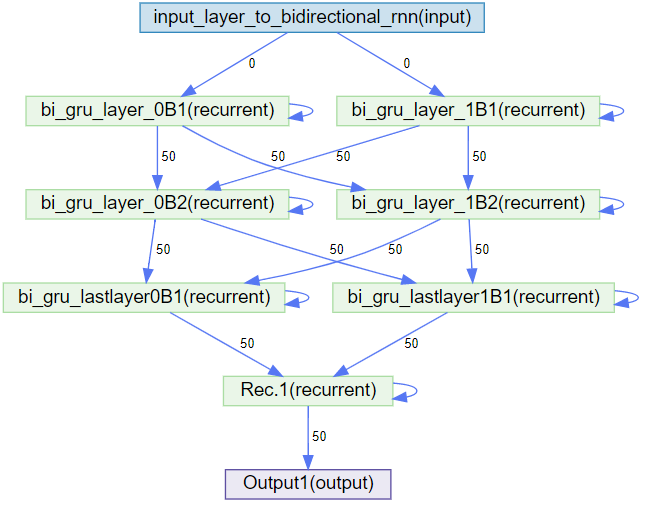

<a id="trainModel1"></a>

#### Train the Simple Text Generation Model

Use `fit()` to train the RNN `text_generation_model` using `toytext_training` data. Within `toytext_training`, use the text data in the input field `text` to generate text for the target `title`. Use the pre-trained word embeddings file `word_embeddings_100` and name the output embedding file `embeddedOut`. Use a mini-batch size of 1, perform a max of 15 epochs, use a learning rate of 0.01, and use basic log reporting. Values for `seed` and `record_seed` are provided to create a deterministic example with repeatable results. 

In [16]:
# train the text generation model

text_generation_model.fit(data='toytext_training', 
                          target='title', 
                          inputs=['text'], 
                          texts=['text', 'title'],
                          text_parms=TextParms(init_input_embeddings='word_embeddings_100', 
                                               model_output_embeddings=dict(name='embeddedOut',
                                                                            replace=True
                                                                            )
                                               ),
                          mini_batch_size=1, 
                          max_epochs=50, 
                          lr=0.01, 
                          # specifies the random seed for the random number generator.
                          seed=867,
                          # specifies the random seed for record selection within a worker.
                          record_seed=5309,
                          log_level=2
                          )

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 177477.
NOTE:  The approximate memory cost is 54.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       2.81 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The maximum mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Target variable: title
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.01           4.303          1     0.03
NOTE:  1          0.01           4.623          1     0.04
NOTE:  2          0.01           4.518          1     0.02
NOTE:  3          0.01           4.455          1     0.01
NOTE:  4          0.01           4.523          1     0.02
NOTE:  5          0.01           4.397          1     0.02
NO

,Descr,Value
0,Model Name,text_generator
1,Model Type,Recurrent Neural Network
2,Number of Layers,9
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,7
9,Number of Weight Parameters,176350


The resulting trained RNN text generation network has 1 input layer, 3 bi-directional blocks, 1 recurrent layer, and 1 output layer. The model network has a total of 177,477 parameters.

The trained model `text_generation_model` has a loss of 4.116216 and a fit error of 0.875000. 

Use `tableinfo()` to verify that the trained model weights are saved.

In [17]:
# Verify that the table of trained model 
# weights 'TEXT_GENERATOR_WEIGHTS' was created.
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,2021-04-21T10:22:54-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,2021-04-21T10:22:51-04:00,1.934634e+09
1,TOYTEXT_TRAINING,9,2,0,utf-8,2021-04-21T10:22:52-04:00,2021-04-21T10:22:52-04:00,2021-04-21T10:22:54-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
2,TOYTEXT_TEST,9,2,0,utf-8,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
3,TEXT_GENERATOR,136,5,0,utf-8,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,2021-04-21T10:22:54-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
4,TEXT_GENERATOR_WEIGHTS,177477,3,0,utf-8,2021-04-21T10:22:57-04:00,2021-04-21T10:22:57-04:00,2021-04-21T10:22:57-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
5,EMBEDDEDOUT,76,102,0,utf-8,2021-04-21T10:22:57-04:00,2021-04-21T10:22:57-04:00,2021-04-21T10:22:57-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN


<a id="scoreData"></a>

### Score the Test Data

Use the trained RNN text generation model `text_generation_model` to score the test data set. Use the `predict()` function with `word_embeddings` to score `toytext_test`. 

Remember, the test data contains only 3 observations.

In [18]:
# Score the test data using the trained 
# text_generation_model. Inference will 
# generate a title for the input text passages.

text_generation_model.predict(data='toytext_test',
                              text_parms=TextParms(init_input_embeddings='word_embeddings_100',
                                                   init_output_embeddings='embeddedOut', 
                                                   has_output_term_ids=True
                                                  )
                              )

r = text_generation_model.valid_res_tbl.fetch(to=3)

NOTE: Due to data distribution, miniBatchSize has been limited to 9.


In [19]:
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,WORD_EMBEDDINGS_100,398921,101,0,utf-8,2021-04-21T10:22:51-04:00,2021-04-21T10:22:51-04:00,2021-04-21T10:22:58-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,2021-04-21T10:22:51-04:00,1.934634e+09
1,TOYTEXT_TRAINING,9,2,0,utf-8,2021-04-21T10:22:52-04:00,2021-04-21T10:22:52-04:00,2021-04-21T10:22:54-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
2,TOYTEXT_TEST,9,2,0,utf-8,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,2021-04-21T10:22:58-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
3,TEXT_GENERATOR,136,5,0,utf-8,2021-04-21T10:22:53-04:00,2021-04-21T10:22:53-04:00,2021-04-21T10:22:58-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
4,TEXT_GENERATOR_WEIGHTS,177477,3,0,utf-8,2021-04-21T10:22:57-04:00,2021-04-21T10:22:57-04:00,2021-04-21T10:22:58-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
5,EMBEDDEDOUT,76,102,0,utf-8,2021-04-21T10:22:57-04:00,2021-04-21T10:22:57-04:00,2021-04-21T10:22:58-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN
6,VALID_RES_HCWTZU,9,3,0,utf-8,2021-04-21T10:22:59-04:00,2021-04-21T10:22:59-04:00,2021-04-21T10:22:59-04:00,UTF8,1.934634e+09,...,0,0,0,,,0,chrobi,,,NaN


<a id="sampleInput"></a>

#### Display Sample Input Text from Scored Table

Use `Fetch` to display the contents of the input text field from the first observation of the scored test table:

In [20]:
r.Fetch['text'][1]

"Ten more moons have been confirmed to orbit around Jupiter, bringing the planet's total known satellite count to 79. That's the highest number of moons of any planet in the Solar System. And these newly discovered space rocks are giving astronomers insight as to why the Jupiter system looks like it does today."

<a id="sampleTitle"></a>

#### Display Sample Generated Title from Scored Table

Use `Fetch` to display the contents of the generated title for the text in the first observation of the scored test table: 

In [21]:
r.Fetch['title'][1]

'Astronomers have found a new crop of moons around Jupiter, and one of them is a weirdo'

<a id="summary"></a>

### Summary

It is relatively easy to create and modify task-centric models using SAS DLPy. This example showed how to use SAS DLPy to create a simple RNN text generation model that performs a title text generation task using toy train and score data sets.